In [1]:
! pip install -q kaggle
print("Upload kaggle.json file")
from google.colab import files
files.upload()


!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

from google.colab import drive
drive.mount('/gdrive')

Upload kaggle.json file


Saving kaggle.json to kaggle.json
Mounted at /gdrive


In [2]:
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
!unzip -qq /content/tuberculosis-tb-chest-xray-dataset.zip

100% 961M/961M [00:16<00:00, 61.5MB/s]
100% 961M/961M [00:16<00:00, 59.9MB/s]


In [3]:
!pip install -U efficientnet
!pip install scikit-optimize
import efficientnet.keras as efn 
%tensorflow_version 1.x
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.io as sio
import os
import sys

from keras.applications.vgg19  import VGG19
from keras.applications.vgg16  import VGG16
from keras.applications.resnet  import ResNet101
from keras.applications.densenet  import DenseNet121
from keras.backend import expand_dims
from keras.applications.densenet   import DenseNet201
from keras.models import Model
from keras.utils import Sequence
from keras.layers import Dense, GlobalAveragePooling2D,Flatten,add,concatenate,Dropout,LSTM,Bidirectional,MaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import Input
from keras import callbacks
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
import pickle
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import ConvLSTM2D, Bidirectional, BatchNormalization, Conv3D, Cropping3D, ZeroPadding3D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from keras.callbacks import *
from keras.optimizers import *
from keras.layers import *
from keras.models import load_model
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args
from skopt import dump, load


     |████████████████████████████████| 51kB 6.0MB/s 
     |████████████████████████████████| 102kB 7.8MB/s 
TensorFlow is already loaded. Please restart the runtime to change versions.


In [6]:
dim_learning_rate = Real(low=1e-6, high=1e-1, prior='log-uniform',
                         name='learning_rate')
dim_num_dense_layers = Integer(low=1, high=10, name='num_dense_layers')
dim_num_dense_nodes = Integer(low=5, high=512, name='num_dense_nodes')
dim_activation = Categorical(categories=['relu', 'sigmoid','linear','tanh'],
                             name='activation')
dim_optimizer  = Categorical(categories=['Adam','SGD','RMSprop','Adadelta','Adagrad'],
                             name='optimizer')
dimensions = [dim_learning_rate,
              dim_num_dense_layers,
              dim_num_dense_nodes,
              dim_activation,
              dim_optimizer]

default_parameters = [1e-5, 1, 16, 'relu','Adam'] 

In [7]:
from keras import backend as K
def create_model(learning_rate, num_dense_layers,
                 num_dense_nodes, activation,optimizer):
    
    model = Sequential()

    model.add(InputLayer(input_shape=(X_train.shape[1])))
    
    for i in range(num_dense_layers):
        name = 'layer_dense_{0}'.format(i+1)

        # add dense layer
        model.add(Dense(num_dense_nodes,
                        activation=activation,
                        name=name))

    # use softmax-activation for classification.
    model.add(Dense(y_train.shape[1], activation='softmax'))
    
    # Use the Adam method for training the network.
    #optimizer = Adam(lr=learning_rate)
    
    #compile the model so it can be trained.
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    K.set_value(model.optimizer.learning_rate, learning_rate)    
    
    return model

In [8]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, num_dense_layers,
            num_dense_nodes, activation,optimizer):
    """
    Hyper-parameters:
    learning_rate:     Learning-rate for the optimizer.
    num_dense_layers:  Number of dense layers.
    num_dense_nodes:   Number of nodes in each dense layer.
    activation:        Activation function for all layers.
    """

    # Print the hyper-parameters.
    # print('learning rate: {0:.1e}'.format(learning_rate))
    # print('num_dense_layers:', num_dense_layers)
    # print('num_dense_nodes:', num_dense_nodes)
    # print('activation:', activation)
    # print('optimizer:', optimizer)
    
    # print()
    
    # Create the neural network with these hyper-parameters.
    model = create_model(learning_rate=learning_rate,
                         num_dense_layers=num_dense_layers,
                         num_dense_nodes=num_dense_nodes,
                         activation=activation,
                         optimizer = optimizer)

    # Dir-name for the TensorBoard log-files.
    log_dir = log_dir_name(learning_rate, num_dense_layers,
                           num_dense_nodes, activation)
    
    # Create a callback-function for Keras which will be
    # run after each epoch has ended during training.
    # This saves the log-files for TensorBoard.
    # Note that there are complications when histogram_freq=1.
    # It might give strange errors and it also does not properly
    # support Keras data-generators for the validation-set.

    # callback_log = TensorBoard(
    #     log_dir=log_dir,
    #     histogram_freq=0,
    #     write_graph=True,
    #     write_grads=False,
    #     write_images=False)
    
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=100, verbose=0, mode='auto', restore_best_weights=True)   
    # Use Keras to train the model.

    global ITERASYON_NO
    ITERASYON_NO += 1

    if not os.path.exists(os.path.join(RESULT_FOLDER,MODEL,str(ITERASYON_NO))):
        os.makedirs(os.path.join(RESULT_FOLDER,MODEL,str(ITERASYON_NO)))

    try:
      history = model.fit(x= X_train,
                          y= y_train,
                          epochs=2000,
                          verbose=0,
                          batch_size=128,
                          validation_data=validation_data,
                          callbacks=[monitor])

      # Get the classification accuracy on the validation-set
      # after the last training-epoch.
      #accuracy = history.history['val_acc'][-1]

      pred_val = model.predict(X_validation)
      score_val = accuracy_score(np.argmax(y_validation ,axis=1), np.argmax(pred_val,axis=1))
      print("Test Score :{0:.2%} -- Validation Score :{1:.2%} ".format(score,score_val))

      np.save(os.path.join(RESULT_FOLDER,MODEL,str(ITERASYON_NO),"y_pred.npy"),pred)
      np.save(os.path.join(RESULT_FOLDER,MODEL,str(ITERASYON_NO),"y_true.npy"),y_test)
      np.save(os.path.join(RESULT_FOLDER,MODEL,str(ITERASYON_NO),"y_pred_val.npy"),pred_val)
      np.save(os.path.join(RESULT_FOLDER,MODEL,str(ITERASYON_NO),"y_true_val.npy"),y_validation)
      with open(os.path.join(RESULT_FOLDER,MODEL,str(ITERASYON_NO),"history"), 'wb') as file_pi:
            pickle.dump(history.history, file_pi) 

      accuracy = score_val
    except:
      accuracy = 0.5
      accuracyTest = 0.5
      print("Hata...")


    # Print the classification accuracy.
    # print()
    # print("Accuracy: {0:.2%}".format(accuracy))
    # print()

    # Save the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside
    # of this function.
    global best_accuracy


    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Save the new model to harddisk.
        model.save(path_best_model)
        
        # Update the classification accuracy.
        best_accuracy = accuracy

    # Delete the Keras model with these hyper-parameters from memory.
    del model
    
    # Clear the Keras session, otherwise it will keep adding new
    # models to the same TensorFlow graph each time we create
    # a model with a different set of hyper-parameters.
    K.clear_session()
    
    # NOTE: Scikit-optimize does minimization so it tries to
    # find a set of hyper-parameters with the LOWEST fitness-value.
    # Because we are interested in the HIGHEST classification
    # accuracy, we need to negate this number so it can be minimized.
    return -accuracy
# This function exactly comes from :Hvass-Labs, TensorFlow-Tutorials


#EfficientNET Feature

In [31]:
RESULT_FOLDER = "/content"
MODEL = "EfficientNET"
path_best_model =os.path.join(RESULT_FOLDER,MODEL,'best_model.h5') 
best_accuracy = 0.0
best_test_accuracy = 0.0

if not os.path.exists(os.path.join(RESULT_FOLDER,MODEL)):
  os.makedirs(os.path.join(RESULT_FOLDER,MODEL))

os.chdir(os.path.join(RESULT_FOLDER,MODEL))
!gdown --id 1-02cpQDrm530zAIkHphlQe-8HriicVX0
!gdown --id 1oQjbNw5dZb_C1IfegM7v8ZQHYCIiMmFe
os.chdir(RESULT_FOLDER)

Downloading...
From: https://drive.google.com/uc?id=1-02cpQDrm530zAIkHphlQe-8HriicVX0
To: /content/EfficientNET/X_train.npy
20.2MB [00:00, 177MB/s]
Downloading...
From: https://drive.google.com/uc?id=1oQjbNw5dZb_C1IfegM7v8ZQHYCIiMmFe
To: /content/EfficientNET/search_result
148MB [00:00, 258MB/s]


In [15]:
model = load_model(os.path.join(RESULT_FOLDER,MODEL,"best_model.h5"))
x_test = np.load(os.path.join(RESULT_FOLDER,MODEL,"X_test.npy"))
y_test = np.load(os.path.join(RESULT_FOLDER,MODEL,"y_test.npy"))
y_head = model.predict(x_test)

score = accuracy_score(np.argmax(y_head,axis=1),np.argmax(y_test,axis=1) )
print(score)

confMatris = confusion_matrix(np.argmax(y_head,axis=1),np.argmax(y_test,axis=1) )
print(confMatris)

0.9928571428571429
[[695   4]
 [  6 695]]


In [22]:
res_loaded = load(os.path.join(RESULT_FOLDER,MODEL,"search_result"))



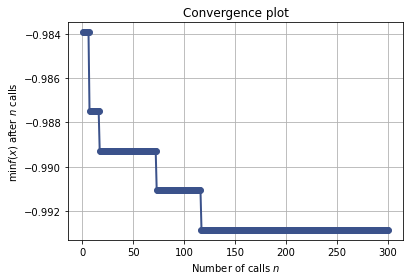

In [24]:
plot_convergence(res_loaded) 

ValueError: ignored

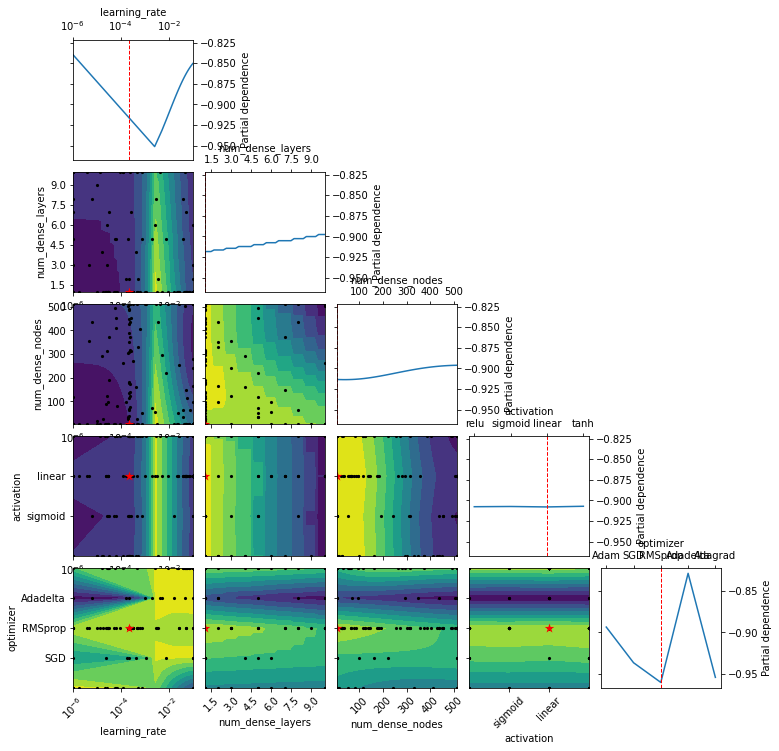

In [27]:
dim_names = ['learning_rate', 'num_dense_layers', 'num_dense_nodes', 'activation','optimizer']
fig, ax = plot_objective(result=res_loaded, dimensions=dim_names)
plt.savefig("all_dimen.png", dpi=400)



ValueError: ignored

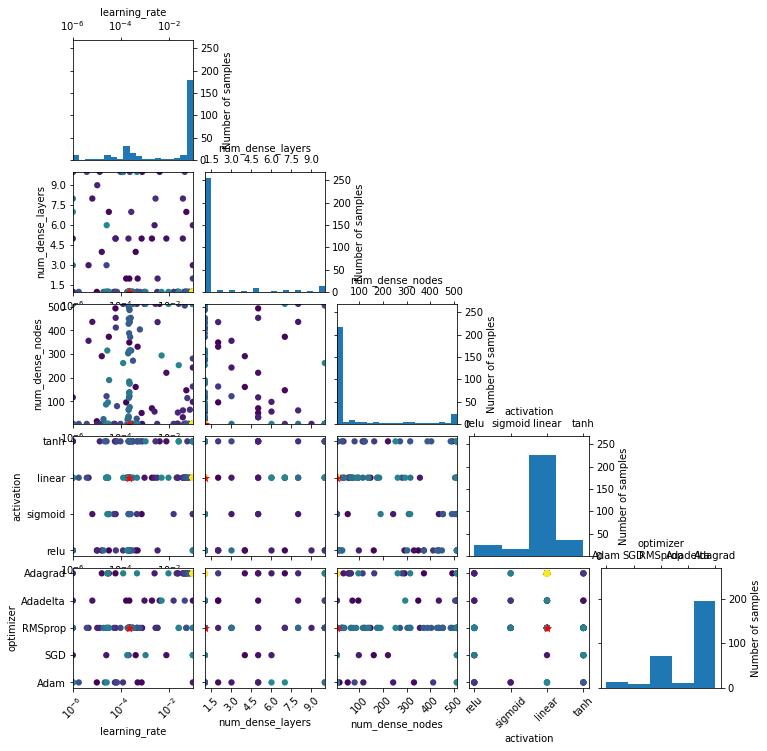

In [28]:
fig, ax = plot_evaluations(result=res_loaded, dimensions=dim_names)

In [29]:
res_loaded.fun

-0.9928571428571429

In [ ]:
#you can restart to optimization
res_loaded = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=300,
                            x0=default_parameters)